In [1]:
import json
import time
import logging
import torch
from torch.nn import functional as F
from torch.nn.parameter import Parameter

from bitsandbytes.triton.int8_matmul_mixed_dequantize import (
    int8_matmul_mixed_dequantize,
)

from bitsandbytes.nn.triton_based_modules import _switchback_global

from bitsandbytes.triton.quantize_rowwise import quantize_rowwise

def get_time(k, fn, X, W, repeat):

    torch.cuda.synchronize()
    start = time.time()
    for _ in range(repeat):
        fn(X, W)
    torch.cuda.synchronize()
    end = time.time()
    ms = (end - start) / repeat * 1000
    print(f"time {k}: {ms:.3f} ms")

def get_time_swichback(k, fn, X, W, b, repeat):
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(repeat):
        fn(X, W, b)
    torch.cuda.synchronize()
    end = time.time()
    ms = (end - start) / repeat * 1000

    torch.cuda.synchronize()
    start = time.time()
    for _ in range(repeat):
        fn(X, W, b)
    torch.cuda.synchronize()
    end = time.time()
    ms = (end - start) / repeat * 1000
    print(f"time {k} after fit-params: {ms:.3f} ms")
    return ms

def standatrt(x, w, b):
    return F.linear(x, w, b)

def swichback(X_3D, W, b):
    
    X = X_3D.view(-1, X_3D.size(-1))
    X_int8, state_X = quantize_rowwise(X)
    W_int8, state_W = quantize_rowwise(W)
    return int8_matmul_mixed_dequantize(X_int8, W_int8.t(), state_X, state_W, None).view(*X_3D.size()[:-1], -1)

def mul_matrix(x_in,x_out, w_in, w_out, repeat):
    x = torch.randn(x_in, x_out, dtype=torch.float16).cuda()
    w = torch.randn(w_in, w_out, dtype=torch.float16).cuda()
    b = torch.empty(w_in, dtype=torch.float16).cuda()
    
    print(f"Running fwd with x size: {x.size()}, w size: {w.size()}")
    standart_time = get_time_swichback("standard_fwd", standatrt, x, w, b, repeat)
    swichback_time = get_time_swichback("swichback", swichback, x, w, b, repeat)
    
    return standart_time, swichback_time

In [2]:
def calculate_times(layers, sequence_length, batch_sizes, repeat=64):
    standard_times = []
    switchback_times = []
    optimal_times = []

    total_standard_times = []
    total_switchback_times = []
    total_optimal_times = []

    for batch in batch_sizes:
        batch_standard_times = {}
        batch_switchback_times = {}
        batch_optimal_times = {}

        total_standard_time = 0
        total_switchback_time = 0
        total_optimal_time = 0

        for key, value in layers.items():
            layer_name = key
            size_1, size_2 = value
            batch_size_adjusted = batch * sequence_length

            standard_time, switchback_time = mul_matrix(
                batch_size_adjusted, size_1, size_2, size_1, repeat=repeat
            )

            batch_standard_times[layer_name] = standard_time
            batch_switchback_times[layer_name] = switchback_time
            
            optimal_time = min(standard_time, switchback_time)
            batch_optimal_times[layer_name] = optimal_time

            total_standard_time += standard_time
            total_switchback_time += switchback_time
            total_optimal_time += optimal_time

        standard_times.append(batch_standard_times)
        switchback_times.append(batch_switchback_times)
        optimal_times.append(batch_optimal_times)

        total_standard_times.append(total_standard_time)
        total_switchback_times.append(total_switchback_time)
        total_optimal_times.append(total_optimal_time)

    return {
        "batch_sizes": batch_sizes,
        "standard_times": standard_times,
        "switchback_times": switchback_times,
        "optimal_times": optimal_times,
        "total_standard_times": total_standard_times,
        "total_switchback_times": total_switchback_times,
        "total_optimal_times": total_optimal_times
    }


```
LlamaDecoderLayer(
  (self_attn): LlamaSdpaAttention(
    (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (k_proj): Linear(in_features=2048, out_features=256, bias=False)
    (v_proj): Linear(in_features=2048, out_features=256, bias=False)
    (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (rotary_emb): LlamaRotaryEmbedding()
  )
  (mlp): LlamaMLP(
    (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
    (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
    (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
    (act_fn): SiLU()
  )
  (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
  (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
)
```

In [3]:
layers = {
    'q_proj': [2048, 2048],
    'k_proj': [2048, 256],
    'v_proj': [2048, 256],
    'o_proj': [2048, 2048],
    'gate_proj': [2048, 5632],
    'up_proj': [2048, 5632],
    'down_proj': [5632, 2048]
}

sequence_length = 128
batch_sizes = [4, 8, 16, 32, 64, 128, 256, 512]

results = calculate_times(layers,sequence_length,batch_sizes)
print(results)

Running fwd with x size: torch.Size([512, 2048]), w size: torch.Size([2048, 2048])
time standard_fwd after fit-params: 0.116 ms
time swichback after fit-params: 0.273 ms
Running fwd with x size: torch.Size([512, 2048]), w size: torch.Size([256, 2048])
time standard_fwd after fit-params: 0.059 ms
time swichback after fit-params: 0.200 ms
Running fwd with x size: torch.Size([512, 2048]), w size: torch.Size([256, 2048])
time standard_fwd after fit-params: 0.059 ms
time swichback after fit-params: 0.200 ms
Running fwd with x size: torch.Size([512, 2048]), w size: torch.Size([2048, 2048])
time standard_fwd after fit-params: 0.116 ms
time swichback after fit-params: 0.202 ms
Running fwd with x size: torch.Size([512, 2048]), w size: torch.Size([5632, 2048])
time standard_fwd after fit-params: 0.340 ms
time swichback after fit-params: 0.328 ms
Running fwd with x size: torch.Size([512, 2048]), w size: torch.Size([5632, 2048])
time standard_fwd after fit-params: 0.341 ms
time swichback after fit

In [4]:
results

{'batch_sizes': [4, 8, 16, 32, 64, 128, 256, 512],
 'standard_times': [{'q_proj': 0.11638924479484558,
   'k_proj': 0.05919113755226135,
   'v_proj': 0.059217214584350586,
   'o_proj': 0.11574476957321167,
   'gate_proj': 0.3404691815376282,
   'up_proj': 0.3413669764995575,
   'down_proj': 0.25912001729011536},
  {'q_proj': 0.24927034974098206,
   'k_proj': 0.05555152893066406,
   'v_proj': 0.055518001317977905,
   'o_proj': 0.24940446019172668,
   'gate_proj': 0.4679448902606964,
   'up_proj': 0.46927109360694885,
   'down_proj': 0.4778914153575897},
  {'q_proj': 0.3866627812385559,
   'k_proj': 0.06323680281639099,
   'v_proj': 0.06330758333206177,
   'o_proj': 0.3870539367198944,
   'gate_proj': 0.8753389120101929,
   'up_proj': 0.875476747751236,
   'down_proj': 1.0740645229816437},
  {'q_proj': 0.6212964653968811,
   'k_proj': 0.12185424566268921,
   'v_proj': 0.12174993753433228,
   'o_proj': 0.6580464541912079,
   'gate_proj': 1.7973482608795166,
   'up_proj': 1.794766634702682

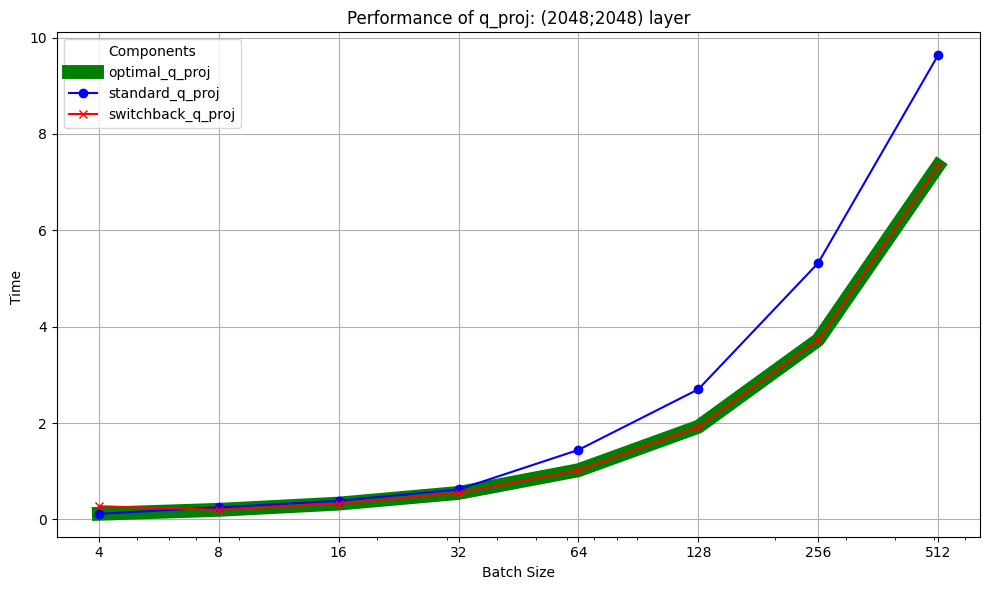

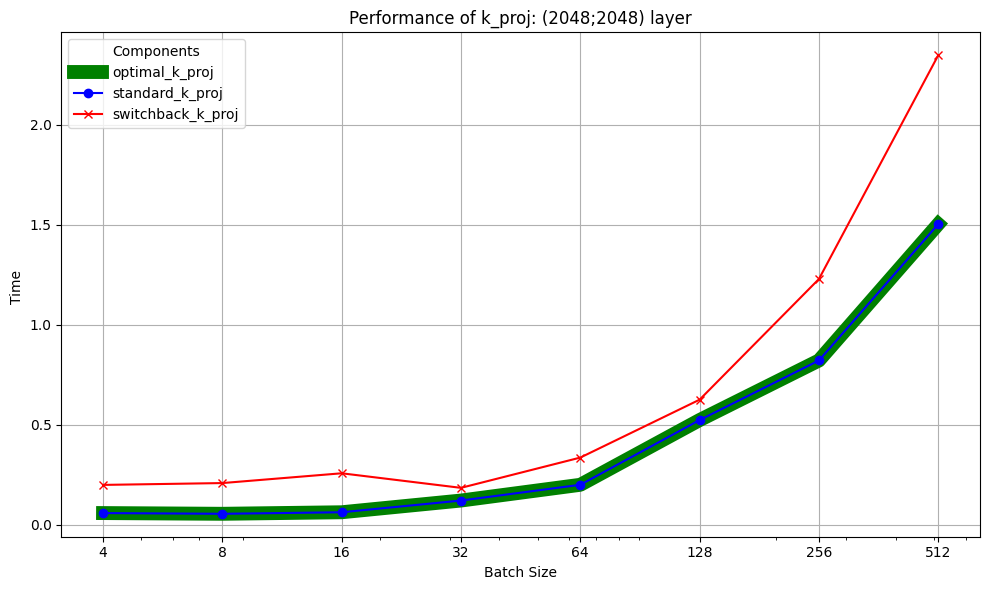

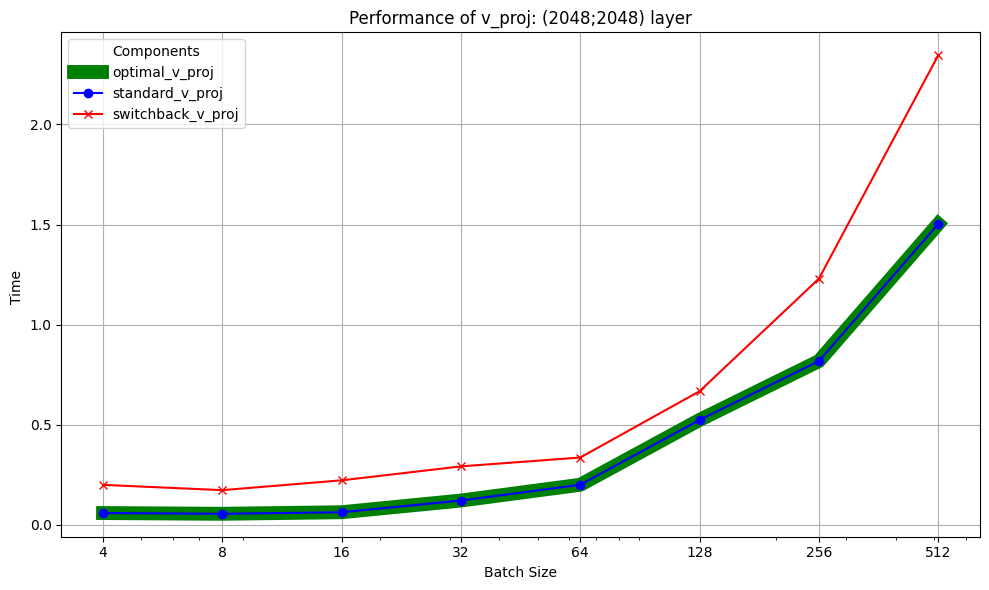

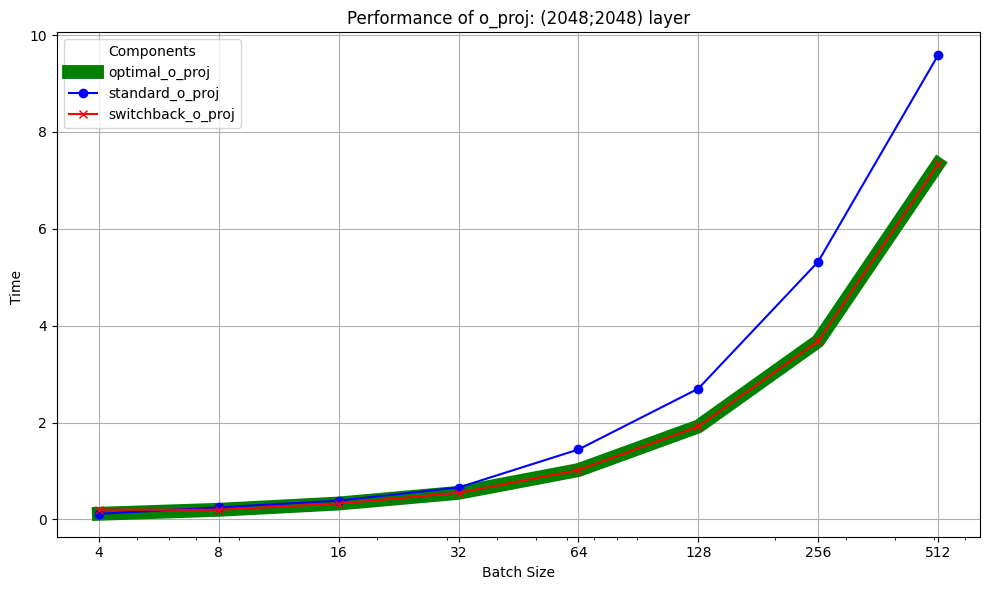

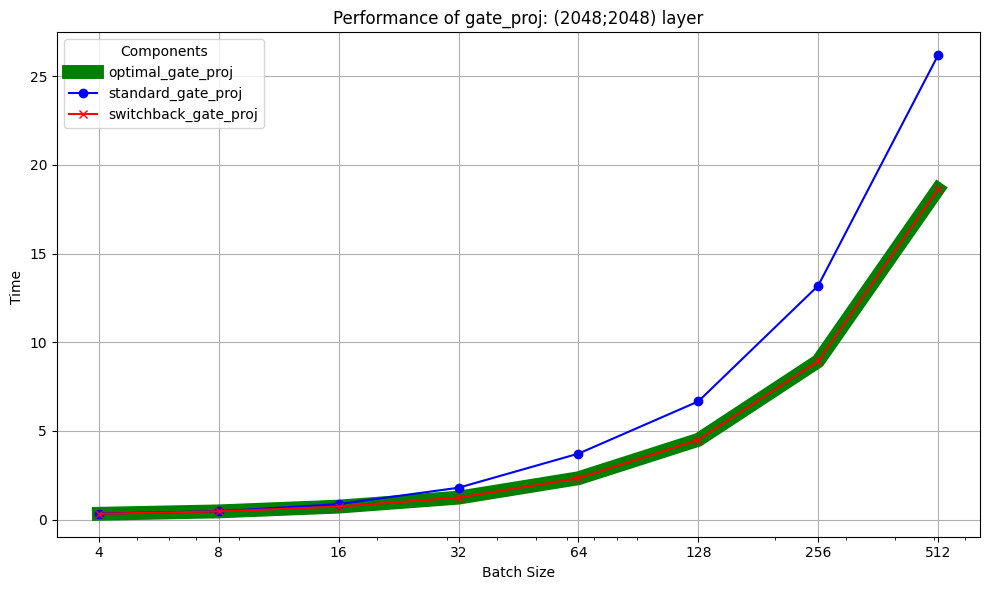

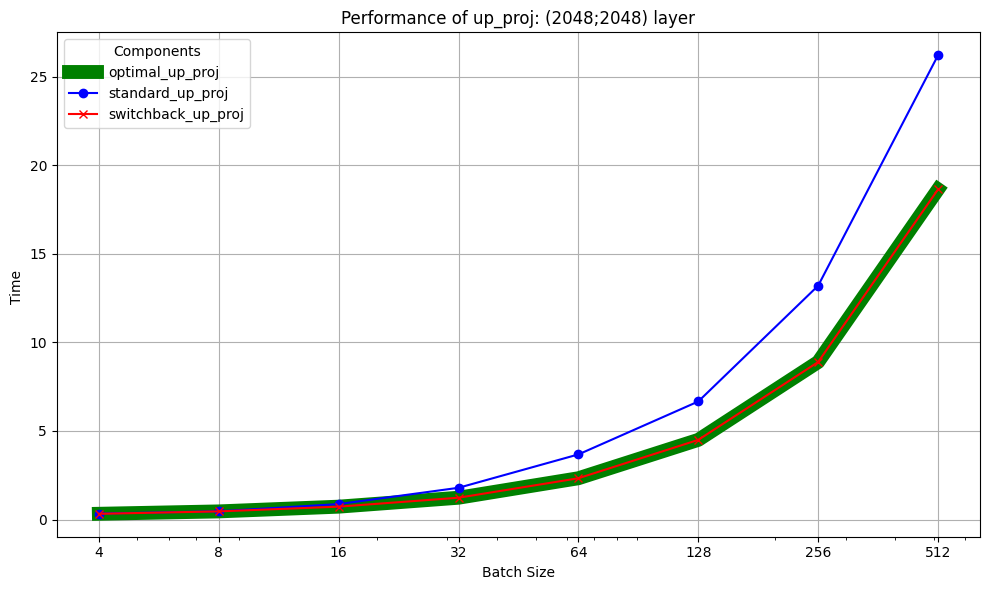

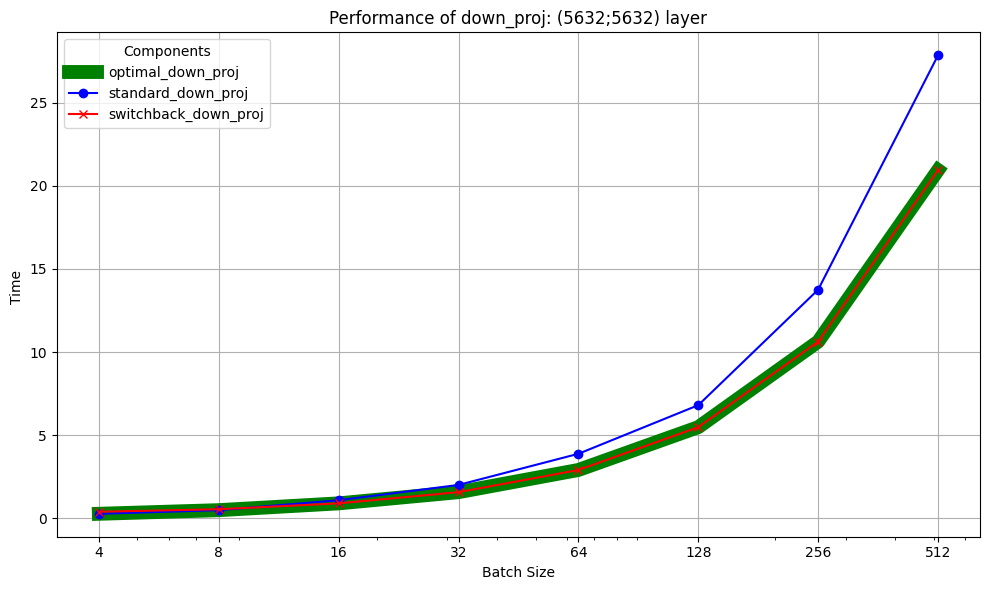

In [5]:
import matplotlib.pyplot as plt
def prepare_layer_data(times):
    layer_data = {layer: [] for layer in times[0].keys()}
    for layer_times in times:
        for layer, time in layer_times.items():
            layer_data[layer].append(time)
    return layer_data

standard_layer_data = prepare_layer_data(results['standard_times'])
switchback_layer_data = prepare_layer_data(results['switchback_times'])
optimal_layer_data = prepare_layer_data(results['optimal_times'])

x_legend_dict = {}
for x in range(len(batch_sizes)):
    x_legend_dict[x] = batch_sizes[x]

def plot_layer_data(batch_sizes, standard_layer_data, switchback_layer_data, optimal_layer_data):
    for key in standard_layer_data.keys():
        plt.figure(figsize=(10, 6))
        plt.plot(batch_sizes, optimal_layer_data[key], label=f'optimal_{key}', marker='*', color = 'green', linewidth=10)
        plt.plot(batch_sizes, standard_layer_data[key], label=f'standard_{key}', marker='o', color ='blue')
        plt.plot(batch_sizes, switchback_layer_data[key], label=f'switchback_{key}', marker='x', color = 'red')
        
        plt.title(f'Performance of {key}: ({layers[key][0]};{layers[key][0]}) layer')
        plt.xlabel('Batch Size')
        plt.ylabel('Time ')
        plt.xscale('log')
        plt.xticks(ticks=batch_sizes, labels=[x_legend_dict[i] for i in range(len(batch_sizes))])
        plt.legend(title='Components')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_layer_data(batch_sizes, standard_layer_data, switchback_layer_data, optimal_layer_data)

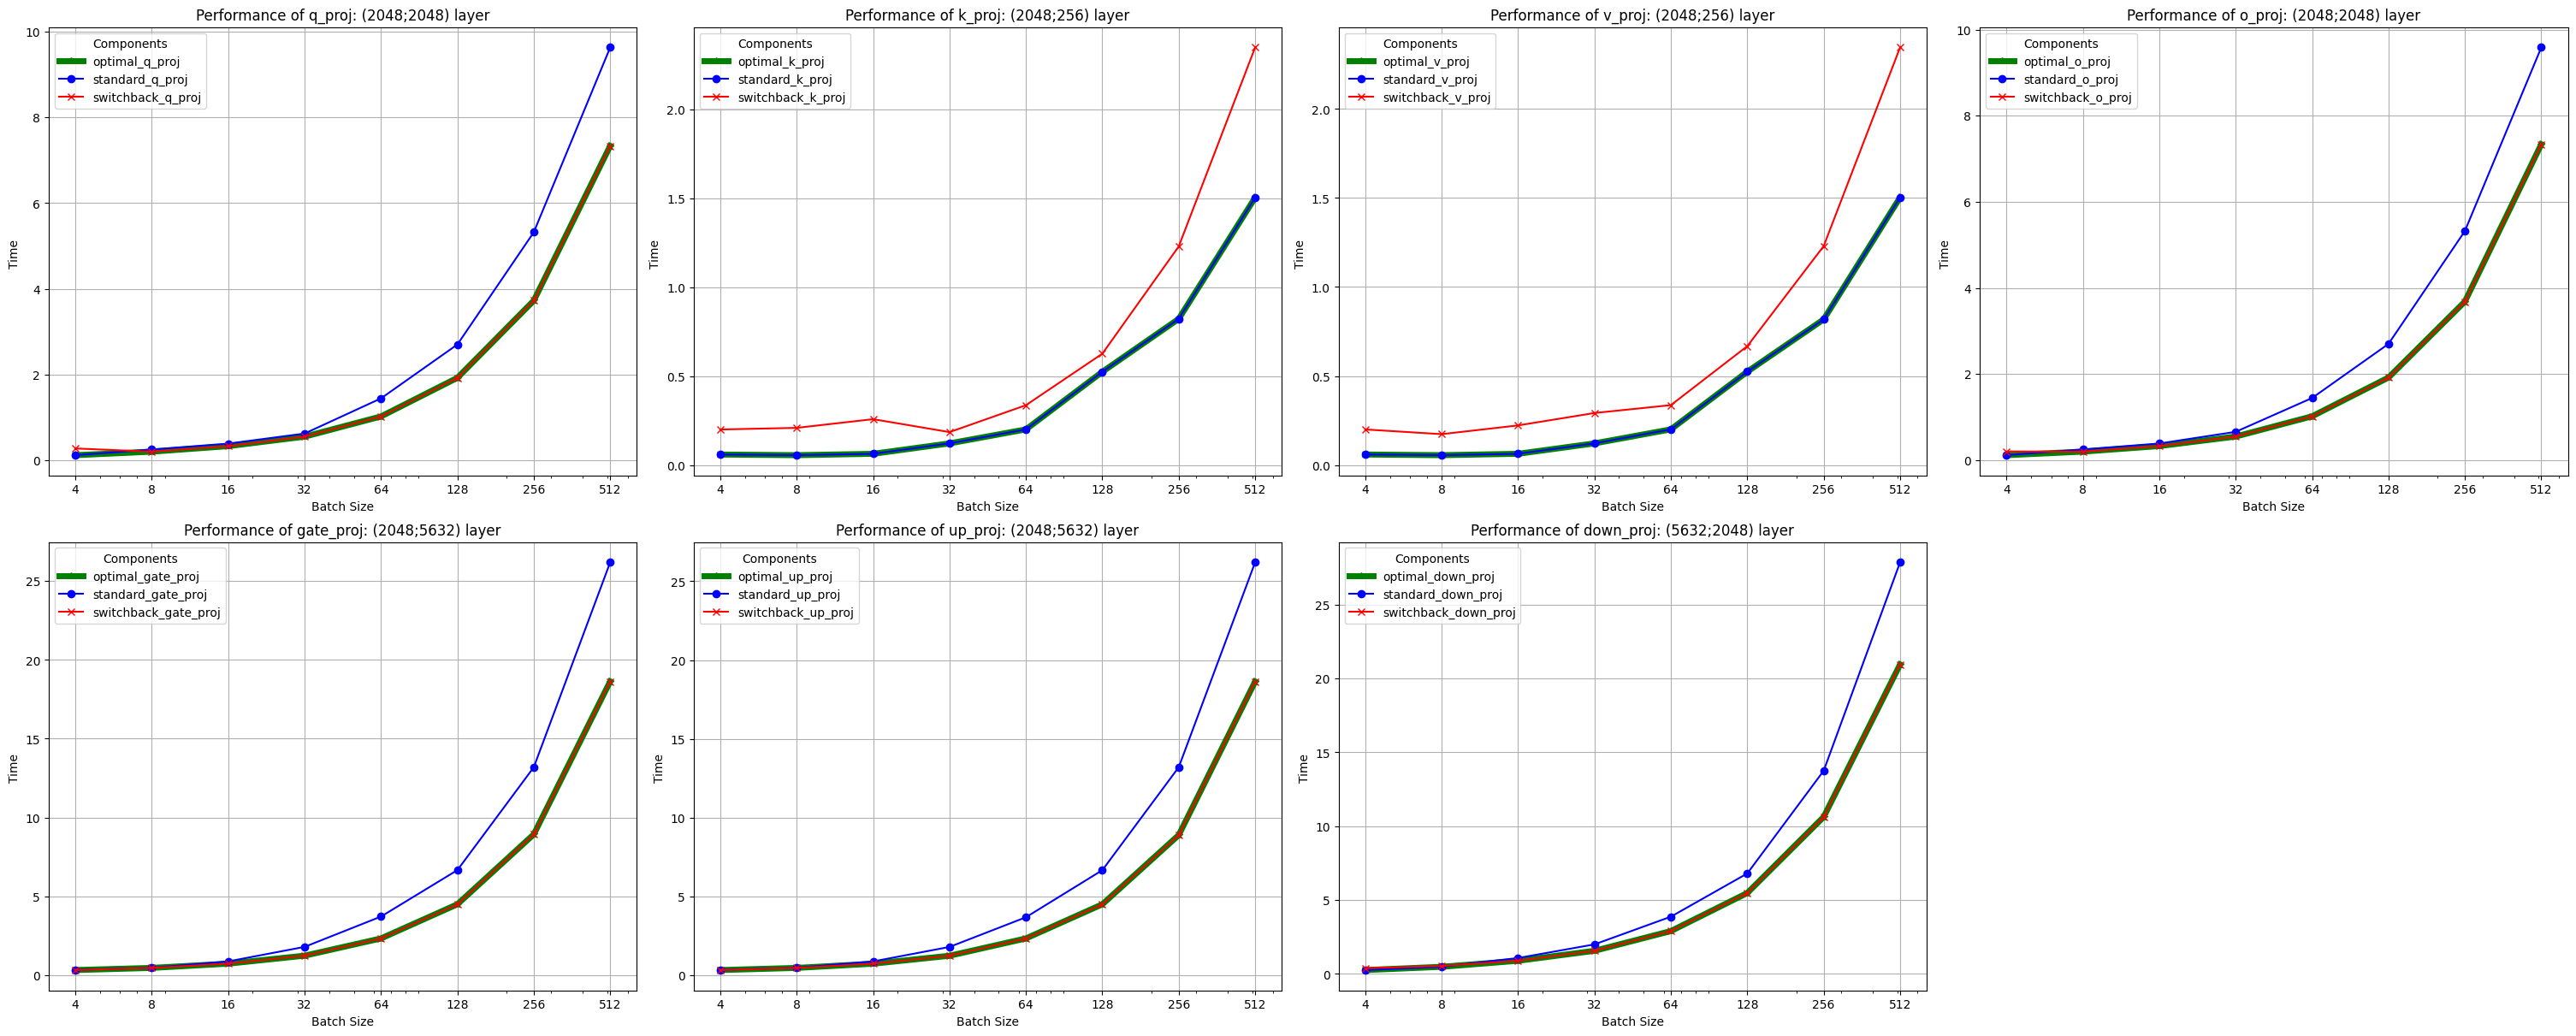

In [6]:
batch_sizes = [4, 8, 16, 32, 64, 128, 256, 512]

x_legend_dict = {}
for x in range(len(batch_sizes)):
    x_legend_dict[x] = batch_sizes[x]

standard_layer_data = prepare_layer_data(results['standard_times'])
switchback_layer_data = prepare_layer_data(results['switchback_times'])
optimal_layer_data = prepare_layer_data(results['optimal_times'])
def plot_layer_data(batch_sizes, standard_layer_data, switchback_layer_data, optimal_layer_data):
    num_layers = len(standard_layer_data)  # Get the number of layers
    ncols = 4  # Set number of columns for subplots
    nrows = (num_layers + 1) // ncols  # Calculate rows needed to fit all layers
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 6 * nrows), constrained_layout=True)

    # Ensure axes is iterable, flatten if more than one row
    if nrows > 1:
        axes = axes.flatten()

    for ax, key in zip(axes, standard_layer_data.keys()):
        ax.plot(batch_sizes, optimal_layer_data[key], label=f'optimal_{key}', marker='*', color='green', linewidth=5)
        ax.plot(batch_sizes, standard_layer_data[key], label=f'standard_{key}', marker='o', color='blue')
        ax.plot(batch_sizes, switchback_layer_data[key], label=f'switchback_{key}', marker='x', color='red')

        ax.set_title(f'Performance of {key}: ({layers[key][0]};{layers[key][1]}) layer')
        ax.set_xlabel('Batch Size')
        ax.set_ylabel('Time ')
        ax.set_xscale('log')
        ax.set_xticks(batch_sizes)
        ax.set_xticklabels([str(x_legend_dict[i]) for i in range(len(batch_sizes))])
        ax.legend(title='Components')
        ax.grid(True)

    # Hide any unused subplots if they exist
    for i in range(num_layers, nrows * ncols):
        fig.delaxes(axes[i])

    plt.show()

plot_layer_data(batch_sizes, standard_layer_data, switchback_layer_data, optimal_layer_data)

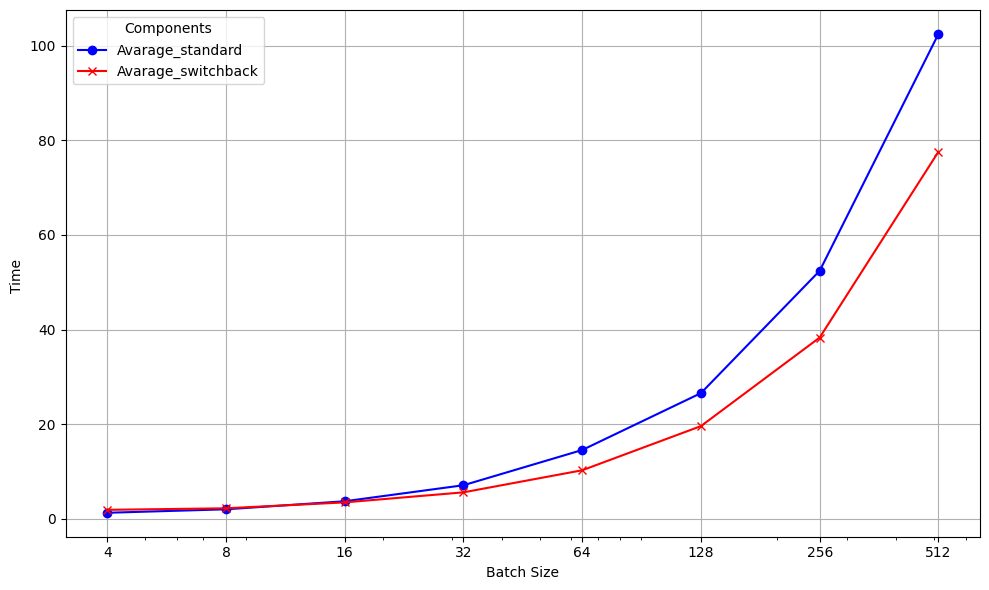

In [7]:
x_values = range(len(batch_sizes))  

x_labels = {}
for x in range(len(batch_sizes)):
    x_labels[x] = batch_sizes[x]

standard_total_times = results['total_standard_times']
switchback_total_times = results['total_switchback_times']
optimal_total_times = results['total_optimal_times']


plt.figure(figsize=(10, 6))
# plt.plot(batch_sizes, optimal_total_times, label=f'Avarage_optimal', marker='*', color = 'green', linewidth=10)
plt.plot(batch_sizes, standard_total_times, label=f'Avarage_standard', marker='o', color ='blue')
plt.plot(batch_sizes, switchback_total_times, label=f'Avarage_switchback', marker='x', color = 'red')

plt.xlabel('Batch Size')
plt.ylabel('Time ')
plt.xscale('log')
plt.xticks(ticks=batch_sizes, labels=[x_legend_dict[i] for i in range(len(batch_sizes))])
plt.legend(title='Components')
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
def calculate_speedup(standard_times, switchback_times, total_standard_times, total_switchback_times):
    layer_speedup_data = {layer: [] for layer in standard_times[0].keys()}
    overall_speedup = []

    for standard_layer_times, switchback_layer_times in zip(standard_times, switchback_times):
        for layer in layer_speedup_data.keys():
            standard_time = standard_layer_times[layer]
            switchback_time = switchback_layer_times[layer]
            speedup = -100 * (switchback_time - standard_time) / standard_time
            layer_speedup_data[layer].append(speedup)


    for total_standard_time, total_switchback_time in zip(total_standard_times, total_switchback_times):
        overall_speedup_value = -100 * (total_switchback_time - total_standard_time) / total_standard_time
        overall_speedup.append(overall_speedup_value)

    return layer_speedup_data, overall_speedup

In [9]:
layer_speedup_data, overall_speedup = calculate_speedup(
    results['standard_times'], 
    results['switchback_times'],
    results['total_standard_times'],
    results['total_switchback_times']
)
layer_speedup_df = pd.DataFrame(layer_speedup_data, index=batch_sizes)
layer_speedup_df.index.name = 'Batch Size'

overall_speedup_df = pd.DataFrame({'Overall Speedup (%)': overall_speedup}, index=batch_sizes)
overall_speedup_df.index.name = 'Batch Size'

layer_speedup_df['Overall Speedup (%)'] = overall_speedup_df['Overall Speedup (%)']
print("Layer Speedup Data (Swichback vs Standard) with Overall Speedup:")
layer_speedup_df.round(2)
layer_speedup_df.round(2).to_csv('Layer Speedup Data (Swichback vs Standard) with Overall Speedup.csv')
layer_speedup_df.round(2)

Layer Speedup Data (Swichback vs Standard) with Overall Speedup:


,q_proj,k_proj,v_proj,o_proj,gate_proj,up_proj,down_proj,Overall Speedup (%)
Batch Size,,,,,,,,
4,-134.79,-237.93,-237.70,-74.54,3.71,3.94,-47.72,-48.18
8,20.46,-276.61,-212.65,20.51,1.03,1.34,-11.68,-10.58
16,15.28,-308.19,-251.77,15.35,16.35,16.57,17.41,6.43
32,11.65,-52.06,-140.12,16.62,31.10,31.21,21.77,21.11
64,29.26,-67.84,-67.84,29.45,37.32,36.55,25.17,29.42
128,28.80,-19.44,-27.34,28.94,32.50,32.50,19.47,26.22
256,30.00,-49.55,-50.31,30.79,32.27,32.63,22.73,26.90
512,23.85,-56.14,-56.04,23.46,28.84,28.88,24.82,24.29


In [10]:
layer_optimal_speedup_data, overall_optimal_speedup = calculate_speedup(
    results['standard_times'], 
    results['optimal_times'],
    results['total_standard_times'],
    results['total_optimal_times']
)

layer_optimal_speedup_df = pd.DataFrame(layer_optimal_speedup_data, index=batch_sizes)
layer_optimal_speedup_df.index.name = 'Batch Size'

overall_optimal_speedup_df = pd.DataFrame({'Overall Speedup (%)': overall_optimal_speedup}, index=batch_sizes)
overall_optimal_speedup_df.index.name = 'Batch Size'

layer_optimal_speedup_df['Overall Speedup (%)'] = overall_optimal_speedup_df['Overall Speedup (%)']

print("Layer Speedup Data (Optimal vs Standard) with Overall Speedup:")
layer_optimal_speedup_df.round(2).to_csv('Layer Speedup Data (Optimal vs Standard) with Overall Speedup.csv')
layer_optimal_speedup_df.round(2)

Layer Speedup Data (Optimal vs Standard) with Overall Speedup:


,q_proj,k_proj,v_proj,o_proj,gate_proj,up_proj,down_proj,Overall Speedup (%)
Batch Size,,,,,,,,
4,-0.00,-0.0,-0.0,-0.00,3.71,3.94,-0.00,2.02
8,20.46,-0.0,-0.0,20.51,1.03,1.34,-0.00,5.59
16,15.28,-0.0,-0.0,15.35,16.35,16.57,17.41,15.94
32,11.65,-0.0,-0.0,16.62,31.10,31.21,21.77,24.41
64,29.26,-0.0,-0.0,29.45,37.32,36.55,25.17,31.29
128,28.80,-0.0,-0.0,28.94,32.50,32.50,19.47,27.14
256,30.00,-0.0,-0.0,30.79,32.27,32.63,22.73,28.47
512,23.85,-0.0,-0.0,23.46,28.84,28.88,24.82,25.94
